In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from PIL import Image
import cv2
import numpy as np
import pickle as pickle
import glob
import settings
%matplotlib inline

### Global settings

In [6]:
example_images = ['./test_images/straight_lines1.jpg', './test_images/straight_lines2.jpg', './test_images/Standard.png', './test_images/Curved.png']
roi_points = np.array([[0, settings.ORIGINAL_SIZE[1] - 50],
                     [settings.ORIGINAL_SIZE[0], settings.ORIGINAL_SIZE[1] - 50],
                     [settings.ORIGINAL_SIZE[0]//2, settings.ORIGINAL_SIZE[1]//2+50]], np.int32)
print('roi_points: ', roi_points)
# Find the region of interest
roi = np.zeros((720, 1280), np.uint8)
print('roi: ', roi.shape)
cv2.fillPoly(roi, [roi_points], 1)


roi_points:  [[   0  670]
 [1280  670]
 [ 640  410]]
roi:  (720, 1280)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

#### Visualize example image

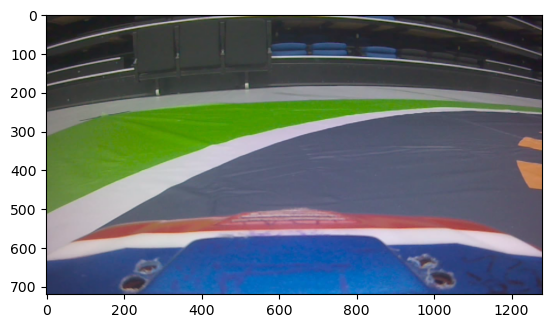

In [7]:
straight_1 = mpimg.imread(example_images[0])
straight_2 = mpimg.imread(example_images[1])

plt.imshow(mpimg.imread(example_images[3]))

#### Apply processing pipeline example

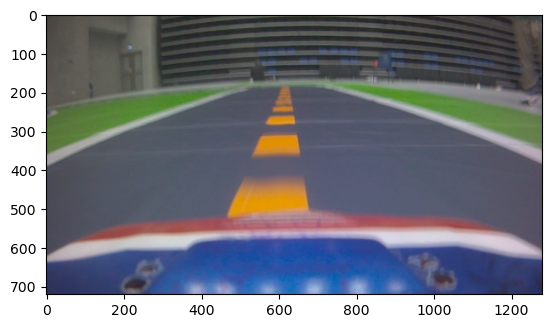

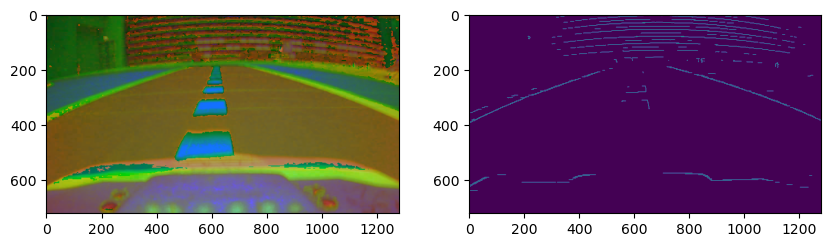

In [8]:
img = np.array(Image.open(example_images[2]))

# img = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(img)
# convert to hls
img_hs1 = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

# Canny on straight_1
# Use the lightness layer to detect lines
low_thresh = 100
high_thresh = 150

# Lightness thresholding (returns less points than saturation thresholding, gives better representation of lane lines)
edges_lightness = cv2.Canny(img_hs1[:,:,1], high_thresh, low_thresh)
r = 1
c = 2
fig = plt.figure(figsize=(10,7))
fig.add_subplot(r, c, 1) 
plt.imshow(img_hs1)
fig.add_subplot(r, c, 2)
plt.imshow(edges_lightness)
plt.show()

width :  1271
vp is :  [[622.30383 ]
 [125.146545]]


Text(0.5, 1.0, 'Vanishing Point visualization')

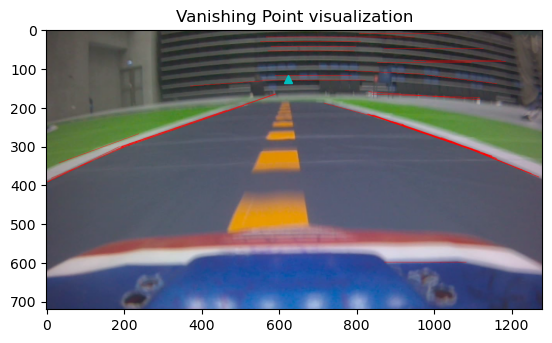

In [9]:
#Line Detection
lines = cv2.HoughLinesP(edges_lightness, 0.5, np.pi/180, 20, None, 180, 120)

Lhs = np.zeros((2, 2), dtype = np.float32)
Rhs = np.zeros((2, 1), dtype = np.float32)
x_max = 0
x_min = 2555
for line in lines:
    for x1, y1, x2, y2 in line:
        # Find the norm (the distances between the two points)
        normal = np.array([[-(y2-y1)], [x2-x1]], dtype = np.float32) # question about this implementation
        normal = normal / np.linalg.norm(normal)
        
        pt = np.array([[x1], [y1]], dtype = np.float32)
        
        outer = np.matmul(normal, normal.T)
        
        Lhs += outer
        Rhs += np.matmul(outer, pt) #use matmul for matrix multiply and not dot product

        cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), thickness = 1)
        
        x_iter_max = max(x1, x2)
        x_iter_min = min(x1, x2)
        x_max = max(x_max, x_iter_max)
        x_min = min(x_min, x_iter_min)

width = x_max - x_min
print('width : ', width)
# Calculate Vanishing Point
vp = np.matmul(np.linalg.inv(Lhs), Rhs)

print('vp is : ', vp)
plt.plot(vp[0], vp[1], 'c^')
plt.imshow(img)
plt.title('Vanishing Point visualization')

### Creating perspective transform

C:\Users\littl\AppData\Local\Temp\ipykernel_94028\1529899185.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m_inv = (p2[0] - p1[0]) / float(p2[1] - p1[1])


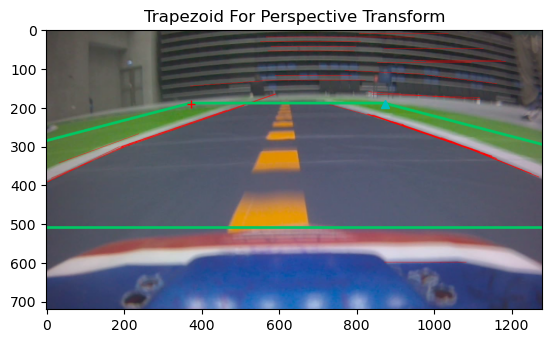

In [10]:
def find_pt_inline(p1, p2, y):
    """
    Here we use point-slope formula in order to find a point that is present on the line
    that passes through our vanishing point (vp). 
    input: points p1, p2, and y. They come is as tuples [x, y]
    We then use the point-slope formula: y - b = m(x - a)
    y: y-coordinate of desired point on the line
    x: x-coordinate of desired point on the line
    m: slope
    b: y-coordinate of p1
    a: x-coodrinate of p1
    x = p1x + (1/m)(y - p1y)
    """
    m_inv = (p2[0] - p1[0]) / float(p2[1] - p1[1])
    Δy = (y - p1[1])
    x = p1[0] + m_inv * Δy
    return [x, y]

top = vp[1] + 65
bot = settings.ORIGINAL_SIZE[1] -210

# Make a large width so that you can grab the lines on the challenge video
width = 500
center = vp[0]
p1 = [center - width/2, top]
p2 = [center + width/2, top]
p3 = find_pt_inline(p2, vp, bot)
p4 = find_pt_inline(p1, vp, bot)

D = [0, 0]
dst_pts = np.float32([[0, 0], [settings.UNWARPED_SIZE[0], 0],
                       [settings.UNWARPED_SIZE[0], settings.UNWARPED_SIZE[1]],
                       [0, settings.UNWARPED_SIZE[1]]])
A = p1[0][0]
src_pts = np.float32([[p1[0][0],p1[1][0]],
                      [p2[0][0],p2[1][0]],
                      [p3[0][0],p3[1]],
                      [p4[0][0],p4[1]]])

# Draw Trapezoid
cv2.polylines(img, [src_pts.astype(np.int32)],True, (0,200,100), thickness=5)
plt.plot(p1[0], p1[1], 'r+')
plt.plot(p2[0], p2[1], 'c^')
plt.plot(p3[0], p3[1], 'r^')
plt.plot(p4[0], p4[1], 'g^')
plt.title('Trapezoid For Perspective Transform')
plt.imshow(img)

True

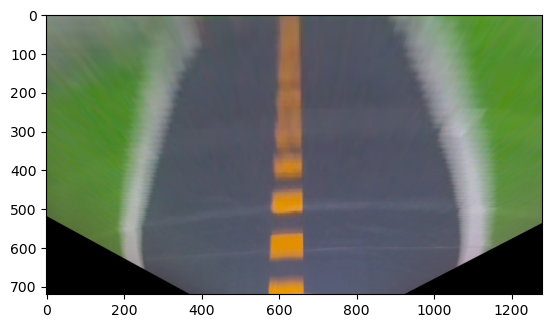

In [14]:
# H is the homography matrix
M_inv = cv2.getPerspectiveTransform(dst_pts, src_pts)
M = cv2.getPerspectiveTransform(src_pts, dst_pts)
warped = cv2.warpPerspective(np.array(Image.open(example_images[2])), M, settings.UNWARPED_SIZE)
plt.imshow(warped)
cv2.imwrite('output_images/warped.png', cv2.cvtColor(warped, cv2.COLOR_RGB2BGR))

### Finding distance

In [15]:
min_width = 1200
for impath in example_images:
    img = cv2.imread(impath)
    # undistory image
    img = cv2.undistort(img, mtx, dist)
    # warp image using homography matrix H
    img = cv2.warpPerspective(img, M, settings.UNWARPED_SIZE)
    # convert to HLS to utilize the luminance channel
    img_hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    # Threshold 
    reg, mask = cv2.threshold(img[:,:,1], 127, 255, cv2.THRESH_BINARY)
    # We know there should be at least a 50 pixel gap between the lane lines
    mask[:,:50] = 0
    mask[:,-50] = 0
    
    offset = settings.UNWARPED_SIZE[0] // 2
    # Centroids are the first order moment MOM['m10'] divided by the zeroth order moment MOM['m00']
    
    # Finding left lane line moment
    MOM = cv2.moments(mask[:,:offset]//1)
    centroid_x1 = MOM['m10'] / MOM['m00']
    plt.plot(centroid_x1, 500, 'c^')
    
    # Right lane moment
    MOM = cv2.moments(mask[:,offset:]//1)
    centroid_x2 = offset + MOM['m10'] / MOM['m00']
    plt.plot(centroid_x2, 500, 'r^')
    
    # Drawlines 
    cv2.line(img, (int(centroid_x1), 0), (int(centroid_x1), settings.UNWARPED_SIZE[1]), (20, 234, 100), 3)
    cv2.line(img, (int(centroid_x2), 0), (int(centroid_x2), settings.UNWARPED_SIZE[1]), (20, 140, 240), 3)
    
    w = abs(centroid_x2 - centroid_x1)
    if w < min_width:
        min_width = w
        
# Use the foot_to_meter conversion, knowing that 1 meter = 3.28084ft
meter_to_feet = 1/3.28084
x_pixels_per_meter = min_width / (12 * meter_to_feet)

# To find the y-pixel per meter we must do a trick, we know that the z-coordinate is 0
# because we are dealing with a plane.
# We seek to find the scalar s to find our y-resolution. (ry)
# If we multiply the homography matrix H (ourput of cv2.getPerspectiveTransform) and our camera coefficient matrix 'mtx',
# we will get our resolutions for each dimension spread across row vectors.
# s = ||h1|| / ||h2||, simply the 1st dimensions norm (x-norm) divided by the 2nd dimensions norm (y-norm)

HM_inv = np.linalg.inv(np.matmul(M, mtx))
x_norm = np.linalg.norm(HM_inv[:,0])
y_norm = np.linalg.norm(HM_inv[:,1])
s = x_norm / y_norm
y_pixels_per_meter = x_pixels_per_meter * s

print('x_pixel_per_meter: ', x_pixel_per_meter)
print('y_pixel_per_meter: ', y_pixel_per_meter)


plt.title('Lane Lines with centroid markings')
plt.imshow(img)
plt.show()

NameError: name 'mtx' is not defined

### Dump pickle data for use later

In [27]:
perspective_transform_data = {'homography_matrix':M, 
                    'x_pixels_per_meter':x_pixels_per_meter,
                    'y_pixels_per_meter':y_pixels_per_meter,
                    'source_points':src_pts
                    }
pickle.dump(perspective_transform_data, open("perspective.p", 'wb'))

### Perspective Transform Box Visualization

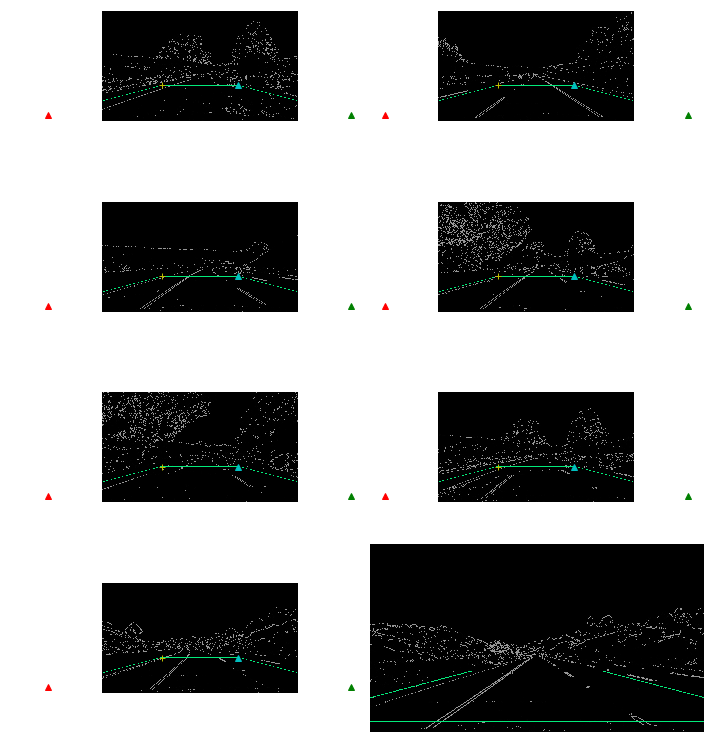

In [23]:
top_left_src = p1 # blue tri
top_right_src = p2 # cyan tri
bot_right_src = p3 # green tri
bot_left_src = p4 # red tri

plt.figure(figsize=(12,14))
gs1 = gridspec.GridSpec(4, 2)
gs1.update(wspace = 0.01, hspace = 0.01)
    
for idx, fname in enumerate(glob.glob('test_images/tracked*.jpg')):
    
    # perspective transform points
    color=[2, 234, 122] 
    thickness=2
    
    plt.plot(top_left_src[0],top_left_src[1], 'y+')
    plt.plot(top_right_src[0], top_right_src[1], 'c^')
    plt.plot(bot_left_src[0], bot_left_src[1], 'r^')
    plt.plot(bot_right_src[0], bot_right_src[1], 'g^')

    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # draw lines connecting the vertices
    img = cv2.line(img, (top_left_src[0], top_left_src[1]), 
         (top_right_src[0], top_right_src[1]), color, thickness)
    
    img = cv2.line(img, (top_right_src[0], top_right_src[1]), 
         (bot_right_src[0], bot_right_src[1]), color, thickness)
    
    img = cv2.line(img, (bot_right_src[0], bot_right_src[1]), 
         (bot_left_src[0], bot_left_src[1]), color, thickness)
    
    img = cv2.line(img,   (bot_left_src[0], bot_left_src[1]), 
         (bot_right_src[0], bot_right_src[1]), color, thickness)
    
    img = cv2.line(img,   (bot_left_src[0], bot_left_src[1]), 
         (top_left_src[0], top_left_src[1]), color, thickness)
    
    ax1 = plt.subplot(gs1[idx])
    ax1.axis('off')
    plt.imshow(img)
plt.show()